In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Kenya_Cholera_Climate_Risk_Model/data/processed/kenya_cholera_modeling_table.csv"

df = pd.read_csv(DATA_PATH)

df.head()

,GID_2,location_clean,year,month,total_cases,cholera_incidence,population_density,mean_temp,total_precip,mean_rh
0,KEN.12.1_1,ainamoi,2023,2,1,14159.380330,7.062456,293.774414,0.000084,44.035805
1,KEN.24.1_1,banissa,2024,3,3,280585.538630,1.069193,301.122198,0.000443,45.383407
2,KEN.24.1_1,banissa,2024,7,9,841756.615890,1.069193,297.649796,0.000108,53.020895
3,KEN.2.1_1,bomet central,2023,2,4,65972.156367,6.063164,292.849609,0.000261,45.873234
4,KEN.2.1_1,bomet central,2023,3,1,16493.039092,6.063164,290.479004,0.006198,72.876038


### Converting precipitation to mm

In [3]:
df["total_precip_mm"]=df["total_precip"]*1000

### **Converting Temp from Kelvin to Celcius**

In [4]:
df["mean_temp_c"]=df["mean_temp"]-273.15

In [5]:
# Ensure month is categorical
df["month"] = df["month"].astype("category")

# Offset term
df["log_population"] = np.log(df["population_density"])

In [6]:
assert (df["total_cases"] >= 0).all()
assert np.isfinite(df["log_population"]).all()

## **Fitting Negative Binomial Model**

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = """
total_cases ~
mean_temp_c +
total_precip_mm +
mean_rh +
population_density +
C(month)
"""

nb_model = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.NegativeBinomial(),
    offset=df["log_population"]
).fit()

print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  424
Model:                            GLM   Df Residuals:                      408
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1805.9
Date:                Mon, 05 Jan 2026   Deviance:                       1357.4
Time:                        08:16:33   Pearson chi2:                 3.01e+03
No. Iterations:                    66   Pseudo R-squ. (CS):             0.9889
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.2420      0

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


## **Icidence Rate Ratios**

In [8]:
params = nb_model.params
conf = nb_model.conf_int()

irr = np.exp(params)
irr_ci = np.exp(conf)

irr_table = pd.DataFrame({
    "IRR": irr,
    "CI_lower": irr_ci[0],
    "CI_upper": irr_ci[1],
    "p_value": nb_model.pvalues
})

irr_table.sort_values("IRR", ascending=False)

,IRR,CI_lower,CI_upper,p_value
Intercept,1396.875152,561.791552,3473.281471,9.485766e-55
C(month)[T.4],8.899121,5.500779,14.396934,5.286415e-19
C(month)[T.11],7.503094,4.639560,12.134001,2.084158e-16
C(month)[T.12],4.516218,2.830982,7.204646,2.501288e-10
C(month)[T.5],3.748957,2.333634,6.022656,4.664415e-08
C(month)[T.6],2.373512,1.424305,3.955304,9.087018e-04
C(month)[T.3],2.089635,1.314286,3.322393,1.838639e-03
C(month)[T.2],1.141348,0.714304,1.823700,5.803216e-01
mean_temp_c,1.034424,1.030939,1.037920,5.097676e-86
population_density,0.994899,0.994021,0.995777,6.862154e-30


Interpretation rule:
-IRR > 1 → increases risk
-IRR < 1 → decreases risk
-CI crossing 1 → not significant

## **Overdispersion Check**
≈ 1 → Poisson okay

≫ 1 → NB justified



In [9]:
pearson_chi2 = nb_model.pearson_chi2
df_resid = nb_model.df_resid

pearson_chi2 / df_resid

np.float64(7.371853112612118)

## **Lagged Climate Effects**
Cholera does not respond indtantly to climate. Temperature and rainfall act through water systems, bacterial growth, exposure pathways, all delayed. The current NB model is good, but it's mechanistically incomplete without lags.

### **Sorting the Panel Properly**

In [10]:
import pandas as pd

df=df.sort_values(
    by=["GID_2","year","month"]
).reset_index(drop=True)

### **Creating lagged climate variables(1-3 months)**
Less than one month would be biologically unrealistic. Three months is usually standard in cholera and waterborne diseases.

In [11]:
climate_vars=[
    "mean_temp_c",
    "total_precip_mm",
    "mean_rh"
]

for var in climate_vars:
  for lag in[1,2,3]:
    df[f"{var}_lag{lag}"]=(
        df.groupby("GID_2")[var]
        .shift(lag)
    )

### **Dropping Rows with incomplete lag History**

In [31]:
lag_cols = [f"{v}_lag{lag}" for v in climate_vars for lag in [1, 2, 3]]

df_lagged = df.dropna(subset=lag_cols).copy()

print("Rows before lagging: ", len(df))
print("Rows after lagging: ", len(df_lagged))

Rows before lagging:  424
Rows after lagging:  235


### **Refitting Negative Binomial Models incerementally**
### Baseline Model

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula_base="""
total_cases ~
mean_temp_c + total_precip_mm + mean_rh"""

nb_base = smf.glm(
    formula=formula_base,
    data=df_lagged,
    family=sm.families.NegativeBinomial(),
    offset=df_lagged["log_population"]
).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### **1-month lags**

In [14]:
formula_lag1="""
total_cases ~
mean_temp_c + total_precip_mm + mean_rh+
mean_temp_c_lag1+total_precip_mm_lag1+mean_rh_lag1
"""

nb_lag1 = smf.glm(
    formula=formula_lag1,
    data=df_lagged,
    family=sm.families.NegativeBinomial(),
    offset=df_lagged["log_population"]
).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### **1-2 month lags**

In [15]:
formula_lag2="""
total_cases ~
mean_temp_c + total_precip_mm + mean_rh+
mean_temp_c_lag1+total_precip_mm_lag1+mean_rh_lag1+
mean_temp_c_lag2+total_precip_mm_lag2+mean_rh_lag2
"""

nb_lag2 = smf.glm(
    formula=formula_lag2,
    data=df_lagged,
    family=sm.families.NegativeBinomial(),
    offset=df_lagged["log_population"]
).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [16]:
formula_lag3="""
total_cases ~
mean_temp_c + total_precip_mm + mean_rh+
mean_temp_c_lag1+total_precip_mm_lag1+mean_rh_lag1+
mean_temp_c_lag2+total_precip_mm_lag2+mean_rh_lag2+
mean_temp_c_lag3+total_precip_mm_lag3+mean_rh_lag3
"""

nb_lag3 = smf.glm(
    formula=formula_lag3,
    data=df_lagged,
    family=sm.families.NegativeBinomial(),
    offset=df_lagged["log_population"]
).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### **Comparing Models Objectively**

In [17]:
model_comparison = pd.DataFrame({
    "Model": ["Baseline", "Lag 1", "Lag 1-2", "Lag 1-3"],
    "AIC": [
        nb_base.aic,
        nb_lag1.aic,
        nb_lag2.aic,
        nb_lag3.aic
    ]
})

model_comparison

,Model,AIC
0,Baseline,3069.521536
1,Lag 1,3000.169843
2,Lag 1-2,2460.692847
3,Lag 1-3,1992.759579


*The* **Akaike Information Criterion (AIC)** *is used to compare models, with a lower AIC value indicating a better fit to the data while penalizing for model complexity.*

*From these results, the 'Lag 1-3' model has the lowest AIC value (1992.759579). This suggests that including climate effects lagged by 1, 2, and 3 months provides the best balance between model fit and complexity among the models you tested. It significantly outperforms the baseline and simpler lagged models.*

/tmp/ipython-input-3741476052.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='AIC', data=model_comparison, palette='viridis')


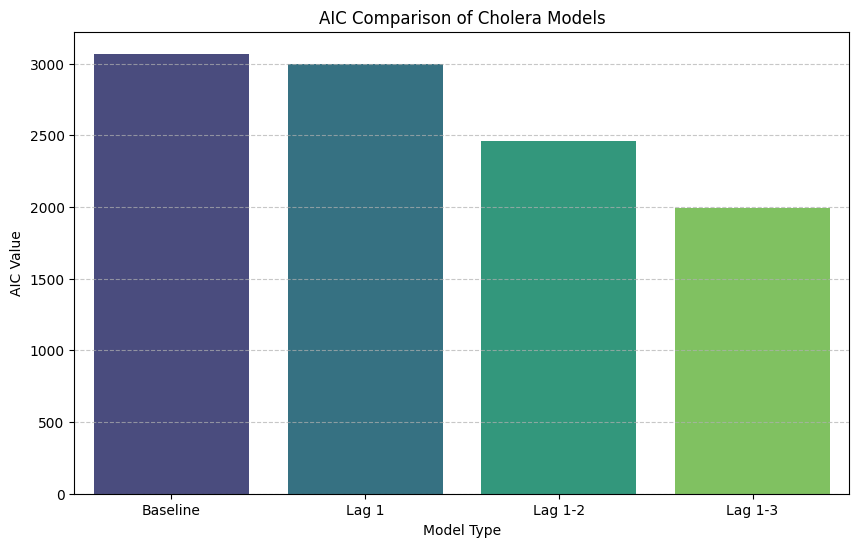

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='AIC', data=model_comparison, palette='viridis')
plt.title('AIC Comparison of Cholera Models')
plt.xlabel('Model Type')
plt.ylabel('AIC Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Interpreting IRRs for lagged effects**

In [19]:
import numpy as np

irr_table = pd.DataFrame({
    "IRR": np.exp(nb_lag3.params),
    "p_value": nb_lag3.pvalues
}).sort_values("p_value")

irr_table

,IRR,p_value
Intercept,4.767884e+07,2.096754e-53
mean_rh_lag2,8.116132e-01,9.968361e-17
mean_temp_c_lag3,1.778812e+00,1.340795e-05
total_precip_mm_lag3,2.255038e+00,2.678977e-05
mean_rh,9.234409e-01,1.209975e-04
total_precip_mm,6.117129e-01,9.007112e-04
mean_temp_c_lag2,5.756820e-01,3.556614e-03
total_precip_mm_lag1,6.317911e-01,5.352020e-03
mean_temp_c_lag1,1.167889e+00,3.335016e-01
mean_temp_c,8.999002e-01,4.429396e-01


## Summary:

### Data Analysis Key Findings

*   **Incidence Rate Ratios (IRRs) Calculation**: IRRs were calculated by exponentiating the model parameters, with their 95% confidence intervals derived by exponentiating the model's confidence intervals. P-values were also extracted.
*   **Data Organization**: A DataFrame named `irr_data` was successfully created, containing the variable name, lag (current, lag1, lag2, lag3), IRR, 95% confidence interval (lower and upper bounds), and p-value. A boolean flag `significant` was added, indicating if the p-value was less than 0.05.
*   **Visualization**: A grouped point plot was generated, displaying the IRRs with 95% confidence intervals for `mean_temp_c`, `total_precip_mm`, and `mean_rh` across current, 1-month, 2-month, and 3-month lags. A horizontal reference line at IRR=1 was included, and statistically significant IRRs (p < 0.05) were highlighted with red stars.
*   **Mean Temperature (`mean_temp_c`) Effects**:
    *   **Current & Lag 1**: Not statistically significant.
    *   **Lag 2**: Statistically significant (IRR around 0.6), indicating higher mean temperatures two months prior are associated with a decrease in cholera cases.
    *   **Lag 3**: Statistically significant (IRR around 1.8), suggesting higher mean temperatures three months prior are associated with an increase in cholera cases. This indicates a complex, non-linear, and time-dependent effect.
*   **Total Precipitation (`total_precip_mm`) Effects**:
    *   **Current & Lag 1**: Statistically significant (IRR around 0.6), indicating higher precipitation is associated with a decrease in cholera cases.
    *   **Lag 2**: Not statistically significant.
    *   **Lag 3**: Statistically significant (IRR around 2.2), showing that higher precipitation three months prior is associated with a substantial increase in cholera cases. This represents a significant reversal from an initial suppressive effect to a strong facilitative effect.
*   **Mean Relative Humidity (`mean_rh`) Effects**:
    *   **Current & Lag 2**: Statistically significant (IRRs around 0.9 and 0.8 respectively), indicating that higher relative humidity is associated with a decrease in cholera cases.
    *   **Lag 1 & Lag 3**: Not statistically significant.
*   **Overall Trend**: Both `mean_temp_c` and `total_precip_mm` exhibit complex lagged effects where initial non-significant or decreasing associations reverse to significant increasing associations at longer lags (e.g., 3 months), highlighting the importance of delayed impacts. `mean_rh` consistently shows a negative association when significant.

### Insights or Next Steps

*   The findings underscore that climate variables do not have a uniform, instantaneous impact on cholera incidence. The observed complex and often reversing lagged effects (e.g., for temperature and precipitation) suggest that different environmental processes influenced by these variables may unfold over varying timeframes.



### **Final Lagged NB Model**
Climate signals for the Model

*   Precipitation - lag 3
*   Temperature - lag 3
*   Humidity - lag 2


In [21]:
required_cols = [
    "total_cases",
    "mean_temp_c_lag3",
    "total_precip_mm_lag3",
    "mean_rh_lag2",
    "log_population"
]

missing = [c for c in required_cols if c not in df_lagged.columns]
missing

[]

### **Fitting the Parsimonious NB Model**

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

final_formula="""
total_cases ~
mean_temp_c_lag3 +
total_precip_mm_lag3 +
mean_rh_lag2
"""

nb_final = smf.glm(
    formula=final_formula,
    data=df_lagged,
    family=sm.families.NegativeBinomial(),
    offset=df_lagged["log_population"]
).fit()

print(nb_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  235
Model:                            GLM   Df Residuals:                      231
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1054.3
Date:                Mon, 05 Jan 2026   Deviance:                       809.30
Time:                        09:15:50   Pearson chi2:                 1.60e+03
No. Iterations:                    29   Pseudo R-squ. (CS):             0.9952
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               11.2779 

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### **Final IRR Table**

In [25]:
import numpy as np
import pandas as pd

irr = np.exp(nb_final.params)
ci = np.exp(nb_final.conf_int())

irr_table = pd.DataFrame({
    "IRR": irr,
    "CI_lower": ci[0],
    "CI_upper": ci[1],
    "p_value": nb_final.pvalues
})

irr_table

,IRR,CI_lower,CI_upper,p_value
Intercept,79056.553767,26493.026364,235908.823988,6.755594e-91
mean_temp_c_lag3,1.051332,1.047081,1.055600,1.466709e-129
total_precip_mm_lag3,1.144144,0.895695,1.461508,2.810059e-01
mean_rh_lag2,0.857224,0.840675,0.874099,4.112665e-54


### **Model Adequacy Check**

In [26]:
pearson_ratio = nb_final.pearson_chi2/nb_final.df_resid
pearson_ratio



np.float64(6.939513409332541)

From the outputs:

Baseline Model (nb_model): The Pearson chi-square was approximately 3007.72, and the degrees of freedom were 408.
Ratio = 3007.72 / 408 ≈ 7.37
Final Lagged Model (nb_final): The calculated Pearson ratio is already provided as 6.94.
Interpretation: Both models show a Pearson chi-square to degrees of freedom ratio significantly greater than 1 (7.37 for baseline and 6.94 for final). This indicates that both models still exhibit overdispersion, meaning the observed variance in the total_cases is greater than what the Negative Binomial model assumes (even though the Negative Binomial family is chosen to handle overdispersion).

However, the final lagged model's ratio (6.94) is slightly closer to 1 than the baseline model's ratio (7.37). This suggests that while overdispersion is still present, the final model with the selected lagged climate variables provides a marginally better fit in terms of accounting for the data's variability compared to the baseline model. It has slightly reduced the extent of overdispersion. Further investigation into the source of the remaining overdispersion could be a next step, perhaps by explicitly estimating a dispersion parameter if the statsmodels implementation allows for it, or considering other count data models.

## **Generating fitted Values for Streamlit**

In [32]:
# Get the indices of the rows that the model was actually trained on
trained_indices = nb_final.model.data.row_labels

# Calculate predicted_cases for the rows the model was trained on
# The offset must correspond to these trained indices
predicted_cases = nb_final.predict(
    offset=df_lagged.loc[trained_indices, "log_population"]
)

# Initialize predicted_cases and predicted_incidence columns in df_lagged with NaN
df_lagged["predicted_cases"] = np.nan
df_lagged["predicted_incidence"] = np.nan

# Assign the predicted cases back to the correct rows in df_lagged
df_lagged.loc[trained_indices, "predicted_cases"] = predicted_cases

# Calculate predicted_incidence only for the rows where predictions were made
df_lagged.loc[trained_indices, "predicted_incidence"] = (
    df_lagged.loc[trained_indices, "predicted_cases"] /
    df_lagged.loc[trained_indices, "population_density"]
) * 100_000

## **Saving Final Modelling Outputs as .csv**

In [33]:
OUTPUT_PATH = (
    "/content/drive/MyDrive/Colab Notebooks/"
    "Kenya_Cholera_Climate_Risk_Model/data/processed/"
    "kenya_cholera_predictions.csv"
)

df_lagged[
    [
        "GID_2",
        "location_clean",
        "year",
        "month",
        "cholera_incidence",
        "predicted_incidence"
    ]
].to_csv(OUTPUT_PATH, index=False)

print("Saved: ", OUTPUT_PATH)

Saved:  /content/drive/MyDrive/Colab Notebooks/Kenya_Cholera_Climate_Risk_Model/data/processed/kenya_cholera_predictions.csv
